# Multiplicative Layer

Idea: use some layers to apply global masking on other layers

Input (batch, axis_1, ..., axis_k, n_channels)
- 1x1 Conv2d + 3x3 Conv2d with padding
- Split in info_channels (l) and mask_channels (m) - ReLU for info channels, sigmoid for mask channles
- Multiplication of all info_channels with all mask_channels 
- 1x1 Conv2d with ReLU

Learning: How to compute layers of information and layers of filters (and finally make a distinction between them)

Interpretation: One Hot Encoding provides us with powerful filters, but linear functions with activation functions applyied to the result lack of the expressive power of boolean filters.

If I have a matrix containing some information (e.g. whatever intensive property) and another one containing binary values saying something about the presence or not of a certain property in a certain cell of the first matrix, with standard neural networks I have a hard time to perform logical operations such as:
"If this is 1 then copy the value, otherwise set it to zero".

With multiplication between layers we just need to do:
matrix1*matrix2 (element wise) and we will have that only the values of the "selected" cells flow, whereas the other ones are set to zero.

I think that the layers/channels resulting from a multiplicative layer could easily summarize properties owned by specific entities, so that if the condition is specific enough (i.e. there is just one of those entities), taking the maximum of that channel will easily yield the information that we want.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class MultiplicativeLayer(nn.Module):
    def __init__(self, n_channels, info_channels, mask_channels, out_channels):
        super(MultiplicativeLayer, self).__init__()
        self.mask_channels = mask_channels
        
        self.info_linear = nn.Conv2d(n_channels, info_channels, kernel_size=1)
        self.mask_linear = nn.Conv2d(n_channels, mask_channels, kernel_size=1)
        self.conv1by1 = nn.Conv2d(info_channels*mask_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        info_layers = F.relu(self.info_linear(x))
        mask_layers = torch.sigmoid(self.mask_linear(x)) 
        out = []
        for m in range(self.mask_channels):
            out.append(info_layers*mask_layers[:,m,...].unsqueeze(1))
        out = torch.cat(out, axis=1)
        out = F.relu(self.conv1by1(out))
        return out

In [12]:
class MultiplicativeLayer_v1(nn.Module):
    def __init__(self, n_channels, info_channels, mask_channels, out_channels):
        super(MultiplicativeLayer_v1, self).__init__()
        self.mask_channels = mask_channels
        
        self.info_linear1by1 = nn.Conv2d(n_channels, info_channels, kernel_size=1)
        self.mask_linear1by1 = nn.Conv2d(n_channels, mask_channels, kernel_size=1)
        self.info_linear3by3 = nn.Conv2d(n_channels, info_channels, kernel_size=3, padding=1)
        self.mask_linear3by3 = nn.Conv2d(n_channels, mask_channels, kernel_size=3, padding=1)
        self.conv1by1 = nn.Conv2d(info_channels*mask_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        info_layers = F.relu(self.info_linear1by1(x) + self.info_linear3by3(x))
        mask_layers = torch.sigmoid(self.mask_linear1by1(x)+self.mask_linear3by3(x)) 
        out = []
        for m in range(self.mask_channels):
            out.append(info_layers*mask_layers[:,m,...].unsqueeze(1))
        out = torch.cat(out, axis=1)
        out = F.relu(self.conv1by1(out))
        return out

In [13]:
n_channels = 5
info_channels = 3 
mask_channels = 2
out_channles = 8

multi_layer = MultiplicativeLayer_v1(n_channels, info_channels, mask_channels, out_channles)
x = torch.rand(5,n_channels,16,16)

In [14]:
multi_layer(x).shape

torch.Size([5, 8, 16, 16])

## Simple architecture to test Sandbox Actor

In [8]:
from Utils import test_env

In [9]:
class PosEncoding(nn.Module):

    def __init__(self):
        super(PosEncoding, self).__init__()

    def forward(self, x):
        """
        Accepts an input of shape (batch_size, linear_size, linear_size, n_channels)
        """
        x_ax = x.shape[-2]
        y_ax = x.shape[-1]
        
        x_lin = torch.linspace(-1,1,x_ax)
        xx = x_lin.repeat(x.shape[0],y_ax,1).view(-1, 1, y_ax, x_ax).transpose(3,2)
        
        y_lin = torch.linspace(-1,1,y_ax).view(-1,1)
        yy = y_lin.repeat(x.shape[0],1,x_ax).view(-1, 1, y_ax, x_ax).transpose(3,2)
        
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    
        x = torch.cat((x,xx.to(device),yy.to(device)), axis=1)
        return x

In [15]:
debug = True

class MultiplicativeNet(nn.Module):
    def __init__(self, in_channels=3, info_channels=2, mask_channels=2, out_channels=6):
        super(MultiplicativeNet, self).__init__()
        
        self.out_channels = out_channels
        
        self.pos_enc = PosEncoding()
        self.multi_layer = MultiplicativeLayer(in_channels+2, info_channels, mask_channels, out_channels)
        self.MLP = nn.Sequential(
                                nn.Linear(out_channels, out_channels),
                                nn.ReLU(),
                                nn.Linear(out_channels, out_channels),
                                nn.ReLU(),
                                nn.Linear(out_channels, out_channels),
                                nn.Sigmoid()
                                )
        
    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        x = self.pos_enc(x)
        if debug: print("x.shape (pos enc): ", x.shape)
            
        x = self.multi_layer(x)
        if debug: print("x.shape (multi layer): ", x.shape)
        
        x = x.reshape((x.shape[0], x.shape[1], -1))
        if debug: print("x.shape (after rehsape): ", x.shape)
        
        x, _ = torch.max(x, axis=-1)
        if debug: print("x.shape (after max): ", x.shape)
        
        x = self.MLP(x)
        if debug: print("x.shape (after MLP): ", x.shape)
            
        return x

In [16]:
# Variable parameters
X = 10
Y = 10
initial = [2,0]
goal = [2,2]
MAX_STEPS = 10

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [17]:
env = test_env.Sandbox(**game_params)

In [18]:
state = env.reset()
state.shape

(3, 12, 12)

In [19]:
HPs = dict(in_channels = 3, info_channels = 3, mask_channels = 2, out_channels = 8)
net = MultiplicativeNet(**HPs)

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print("device: ", device)

net.to(device)

device:  cuda


MultiplicativeNet(
  (pos_enc): PosEncoding()
  (multi_layer): MultiplicativeLayer(
    (info_linear): Conv2d(5, 3, kernel_size=(1, 1), stride=(1, 1))
    (mask_linear): Conv2d(5, 2, kernel_size=(1, 1), stride=(1, 1))
    (conv1by1): Conv2d(6, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (MLP): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): Sigmoid()
  )
)

In [21]:
x = torch.tensor(state).unsqueeze(0).float().to(device)
net(x)

x.shape (pos enc):  torch.Size([1, 5, 12, 12])
x.shape (multi layer):  torch.Size([1, 8, 12, 12])
x.shape (after rehsape):  torch.Size([1, 8, 144])
x.shape (after max):  torch.Size([1, 8])
x.shape (after MLP):  torch.Size([1, 8])


tensor([[0.4233, 0.4374, 0.4852, 0.4750, 0.5305, 0.5389, 0.4214, 0.4910]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [22]:
class MultiplicativeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, info_channels=None, mask_channels=None,
                    hidden_channels=None, kernel_size=3, stride=1, padding=0, version='v0'):
        super(MultiplicativeBlock, self).__init__()
        
        # Set adaptive parameters for multiplicative layer
        if info_channels is None:
            info_channels = in_channels // 2
        if mask_channels is None:
            mask_channels = in_channels // 2
        if hidden_channels is None:
            hidden_channels = 2*in_channels
        
        if version == 'v0':
            self.net = nn.Sequential( 
                     MultiplicativeLayer(in_channels, info_channels, mask_channels, hidden_channels),
                     nn.Conv2d(hidden_channels, out_channels, kernel_size, stride, padding),
                     nn.ReLU()  )
        else:
            self.net = nn.Sequential( 
                     MultiplicativeLayer_v1(in_channels, info_channels, mask_channels, hidden_channels),
                     nn.Conv2d(hidden_channels, out_channels, kernel_size, stride, padding),
                     nn.ReLU()  )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [25]:
multi_block = MultiplicativeBlock(in_channels = 3, out_channels = 16)
multi_block.to(device)

MultiplicativeBlock(
  (net): Sequential(
    (0): MultiplicativeLayer(
      (info_linear): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
      (mask_linear): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
      (conv1by1): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
  )
)

In [26]:
x = torch.tensor(state).unsqueeze(0).float().to(device)
multi_block(x).shape

torch.Size([1, 16, 10, 10])

In [27]:
class ResidualLayer(nn.Module):
    """
    Implements residual layer. Use LayerNorm and ReLU activation before applying the layers.
    """
    def __init__(self, n_features, n_hidden):
        super(ResidualLayer, self).__init__()
        self.norm = nn.LayerNorm(n_features)
        self.w1 = nn.Linear(n_features, n_hidden)
        self.w2 = nn.Linear(n_hidden, n_features)

    def forward(self, x):
        out = F.relu(self.w1(self.norm(x)))
        out = self.w2(out)
        return out + x

In [28]:
debug=True

class MultiplicativeConvNet(nn.Module):
    
    def __init__(self, linear_size, in_channels=3, n_multi_blocks=2, hidden_channels=[12,24], max_pool_size=2,
                 n_features = 64, n_residual_layers=2, residual_hidden_dim=64):
        
        super(MultiplicativeConvNet, self).__init__()
        
        assert len(hidden_channels) == n_multi_blocks, "Provide a list of hidden_channels of the same length of n_multi_blocks"
        
        self.out_channels = hidden_channels[-1]
        self.out_size = self.compute_out_size(linear_size, n_multi_blocks, max_pool_size)
        self.n_features = n_features
        if debug:
            print("Out channels after forward1: ", self.out_channels)
            print("Linear size after forward1: ", self.out_size)
            
        multi_blocks = nn.ModuleList([MultiplicativeBlock(in_channels+2, hidden_channels[0])]+
                                          [MultiplicativeBlock(hidden_channels[i], hidden_channels[i+1]) 
                                           for i in range(n_multi_blocks-1)])
        self.forward1 = nn.Sequential( PosEncoding(), *multi_blocks)
        self.maxpool = nn.MaxPool2d(max_pool_size)
        
        residual_MLP = nn.ModuleList([ResidualLayer(n_features, residual_hidden_dim)
                                      for _ in range(n_residual_layers)])
        self.forward2 = nn.Sequential(nn.Linear(self.out_channels*self.out_size**2, n_features), *residual_MLP)
    
    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        x = self.forward1(x)
        if debug: print("x.shape (after forward1): ", x.shape)
            
        x = self.maxpool(x)
        if debug: print("x.shape (after maxpool): ", x.shape)
            
        x = x.reshape((x.shape[0],-1))
        if debug: print("x.shape (after rehsape): ", x.shape)
        
        x = self.forward2(x)
        if debug: print("x.shape (after residual MLP): ", x.shape)
            
        return x
    
    @staticmethod
    def compute_out_size(linear_size, n_multi_blocks, max_pool_size):
        size = (linear_size - 2*n_multi_blocks) // max_pool_size
        return size

In [29]:
state.shape

(3, 12, 12)

In [30]:
HPs = dict(linear_size = state.shape[-1],
           in_channels = state.shape[0]
          )

multi_convnet = MultiplicativeConvNet(**HPs)

Out channels after forward1:  24
Linear size after forward1:  4


In [32]:
x = torch.tensor(state).unsqueeze(0).float().to(device)
multi_convnet.to(device)
multi_convnet(x).shape

x.shape (after forward1):  torch.Size([1, 24, 8, 8])
x.shape (after maxpool):  torch.Size([1, 24, 4, 4])
x.shape (after rehsape):  torch.Size([1, 384])
x.shape (after residual MLP):  torch.Size([1, 64])


torch.Size([1, 64])

# Looking at  a trained network

In [33]:
load_dir = 'Results/Sandbox/Supervised/'

multi_trained_net = torch.load(load_dir+"net_S_multiplicative_4x4-channels_sigmoid_10by10_10000-samples_100-epochs_lr5e-3_JRWS")

In [34]:
from Utils import test_env

In [35]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 25

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [36]:
env = test_env.Sandbox(**game_params)

In [37]:
grey_state = env.enc_to_grey()
enc_state = env.grey_to_onehot(grey_state)

In [38]:
#info channels
x = torch.tensor(enc_state).float().to(device).unsqueeze(0)
x = multi_trained_net.net.pos_enc(x)
x = x.permute(0,2,3,1)
info_channels = multi_trained_net.net.multi_layer.info_linear(x)
info_channels.shape

torch.Size([1, 12, 12, 4])

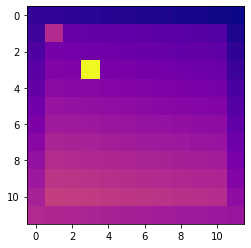

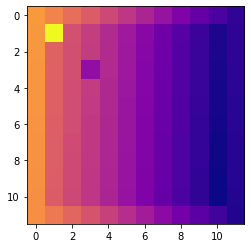

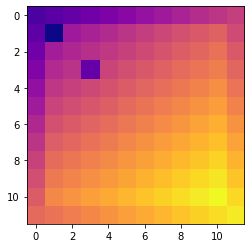

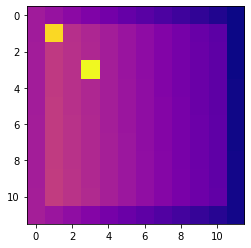

In [39]:
for i in range(info_channels.shape[-1]):
    im = info_channels[...,i].squeeze().cpu().detach().numpy()
    plt.imshow(im, cmap='plasma')
    plt.show()

In [40]:
#mask channels
sigmoid = True

x = torch.tensor(enc_state).float().to(device).unsqueeze(0)
x = multi_trained_net.net.pos_enc(x)
x = x.permute(0,2,3,1)
if sigmoid:
    mask_channels = torch.sigmoid(multi_trained_net.net.multi_layer.mask_linear(x))
else:
    mask_channels = F.relu(multi_trained_net.net.multi_layer.mask_linear(x))
mask_channels.shape

torch.Size([1, 12, 12, 4])

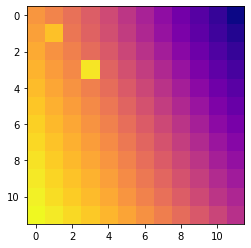

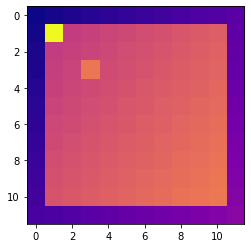

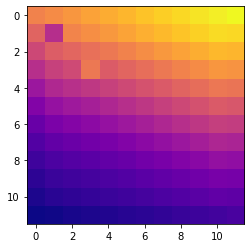

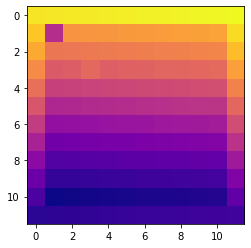

In [41]:
for i in range(mask_channels.shape[-1]):
    im = mask_channels[...,i].squeeze().cpu().detach().numpy()
    plt.imshow(im, cmap='plasma')
    plt.show()